In [7]:
# Import dependencies
import pandas as pd
import datetime
import time
#from sqlalchemy import create_engine
#from config import db_password

# Read in files
df = pd.read_csv('/content/bitcoin_data.csv', low_memory=False)

# Display initial data
df.head(10)

# keep timestamp, high, low, weighted_price
df = df[['Timestamp', 'High', 'Low', 'Volume_(BTC)', 'Weighted_Price']].reset_index(drop=True)

# preprocessing notes-- consider omitting data prior to Jan 1st, 2012 due to higher volatility 
# earlier in bitcoin's lifecycle

# converting Timestamp column to str datatype
df['str_timestamp'] = [str(timestamp) for timestamp in df['Timestamp']]
df['int_timestamp'] = df['str_timestamp'].astype('int32', copy=True)

# filtering df to only include rows after 01/01/2012
df_cleaned_filtered = df.loc[df['int_timestamp'] >= 1325391360]
df_cleaned_filtered.head(2)

# context manager to suppress 1 time SettingWithCopyWarning; alternatively call .loc after timestamp conversion to avoid error
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    df_cleaned_filtered['UTC_time'] = df_cleaned_filtered['int_timestamp'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))

# dropping all null values, followed by evaluation of which time periods had the greatest data loss
final_df = df_cleaned_filtered.dropna().reset_index(drop=True)

# finding percentage of data loss (null values)
btotalLength = (len(df_cleaned_filtered))
bpartialLength = (len(final_df))
bValuesDropped = btotalLength - bpartialLength
bitstampDiff = (btotalLength - bpartialLength) / btotalLength * 100 
totalDays = round(btotalLength/1440,2)
daysDropped = round(bValuesDropped/1440,2)

print(f"Percentage of total Bitstamp data lost due to dropping rows with NaN values: {bitstampDiff:.2f}%")
print(f"Ratio of Bitstamp rows dropped: {bValuesDropped:,}/{btotalLength:,}")
print(f"Total dataset contains {totalDays} days worth of data. Due to data loss, we had to drop {daysDropped} days worth of data")

# Machine learning section
# possible implementation ideas:
# 1. time series forecasting bitcoin price with ARIMA(Auto Regressive Integrated Moving Average)
# Rational for using time series: the 4 components of time series are trends, seasonality (consistent trends that span 1 calender year), noise/irregularity, and cyclicity(trends that can be observed in <1 or >1 year); this is perfect for tradeable assets 
# Qualifying criteria: the dataset must be stationary in order to more accurately fit a time series model. Stationary means that there should be a constant mean with constant std deviation or variance
# We can test if a time series is stationary by plotting the moving avg and/or movning std dev. to see if it changes over time. These results can be supported with an ADCF test
# if testing reveals our time series is NOT stationary, we can perform a variety of transformations to change it (log transform, sq rt, exponential decay etc..)
# SARIMA is ARIMA with a seasonality component. 


# ### PGAdmin SQL Schema
# db schema thoughts: can create multiple tables for each currency (1 for btc, 1 ethereum, 1 xrp)
# can also add in additional tables down the line to support our analysis (table with google analytics, table with twitter search results for sentiment analysis)

final_df.head(5)

# Rename columns to be sql friendly
final_df.rename({'Timestamp':'timestamp',
                  'High':'high',
                  'Low':'low',
                  'Volume_(BTC)':'volume',
                  'Weighted_Price':'weightedPrice',
                  'str_timestamp':'timestampSTR',
                  'int_timestamp':'timestampINT',
                  'UTC_time':'timeUTC',
                  'time_delta':'timeDelta'
                 }, axis='columns', inplace=True)


# Checking datatypes
print(final_df.dtypes)
final_df.head(2)

Percentage of total Bitstamp data lost due to dropping rows with NaN values: 31.46%
Ratio of Bitstamp rows dropped: 1,231,032/3,913,038
Total dataset contains 2717.39 days worth of data. Due to data loss, we had to drop 854.88 days worth of data
timestamp                 int64
high                    float64
low                     float64
volume                   object
weightedPrice           float64
timestampSTR             object
timestampINT              int32
timeUTC          datetime64[ns]
dtype: object


,timestamp,high,low,volume,weightedPrice,timestampSTR,timestampINT,timeUTC
0,1325391360,4.58,4.58,1.502,4.58,1325391360,1325391360,2012-01-01 04:16:00
1,1325431680,4.84,4.84,10,4.84,1325431680,1325431680,2012-01-01 15:28:00


In [8]:
print(len(final_df))
final_df['normalised_date'] = final_df['timeUTC'].dt.normalize()
final_df.head()
print(len(final_df))

2682006
2682006


In [9]:
final_df['date_only'] = final_df['normalised_date']
aggregated_df = final_df.groupby(final_df.normalised_date.dt.date).mean()
print(len(aggregated_df))
print(aggregated_df.columns)
aggregated_df


2710
Index(['timestamp', 'high', 'low', 'weightedPrice', 'timestampINT'], dtype='object')


,timestamp,high,low,weightedPrice,timestampINT
normalised_date,,,,,
2012-01-01,1.325427e+09,4.806667,4.806667,4.806667,1.325427e+09
2012-01-02,1.325535e+09,5.000000,5.000000,5.000000,1.325535e+09
2012-01-03,1.325605e+09,5.252500,5.252500,5.252500,1.325605e+09
2012-01-04,1.325682e+09,5.223333,5.200000,5.208159,1.325682e+09
2012-01-05,1.325771e+09,6.286190,6.281429,6.284127,1.325771e+09
...,...,...,...,...,...
2019-06-01,1.559390e+09,8548.073880,8538.870698,8543.924060,1.559390e+09
2019-06-02,1.559477e+09,8674.351111,8664.817862,8670.265813,1.559477e+09
2019-06-03,1.559563e+09,8538.372726,8526.150090,8532.593173,1.559563e+09


In [12]:
 # importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
#from pmdarima import auto_arima as AA
import warnings
import os
#from statsmodels.tsa.statespace.sarimax import SARIMAX
import regex as re


date_price_df = aggregated_df[['weightedPrice']]

y_2012 = date_price_df.loc[datetime.date(year=2012,month=1,day=1):datetime.date(year=2012,month=12,day=31)]
y_2013 = date_price_df.loc[datetime.date(year=2013,month=1,day=1):datetime.date(year=2013,month=12,day=31)]
y_2014 = date_price_df.loc[datetime.date(year=2014,month=1,day=1):datetime.date(year=2014,month=12,day=31)]
y_2015 = date_price_df.loc[datetime.date(year=2015,month=1,day=1):datetime.date(year=2015,month=12,day=31)]
y_2016 = date_price_df.loc[datetime.date(year=2016,month=1,day=1):datetime.date(year=2016,month=12,day=31)]
y_2017 = date_price_df.loc[datetime.date(year=2017,month=1,day=1):datetime.date(year=2017,month=12,day=31)]
y_2018 = date_price_df.loc[datetime.date(year=2018,month=1,day=1):datetime.date(year=2018,month=12,day=31)]
y_2019 = date_price_df.loc[datetime.date(year=2019,month=1,day=1):datetime.date(year=2019,month=12,day=31)]

In [13]:
y = date_price_df
y

,weightedPrice
normalised_date,
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159
2012-01-05,6.284127
...,...
2019-06-01,8543.924060
2019-06-02,8670.265813
2019-06-03,8532.593173


In [14]:
print(f'length of data:\n 2012: {len(y_2012)}\n 2013: {len(y_2013)}\n 2014: {len(y_2014)}\n 2015: {len(y_2015)}\n 2016: {len(y_2016)}\n 2017: {len(y_2017)}\n 2018: {len(y_2018)}\n 2019: {len(y_2019)}')

length of data:
 2012: 366
 2013: 365
 2014: 365
 2015: 362
 2016: 366
 2017: 365
 2018: 365
 2019: 156


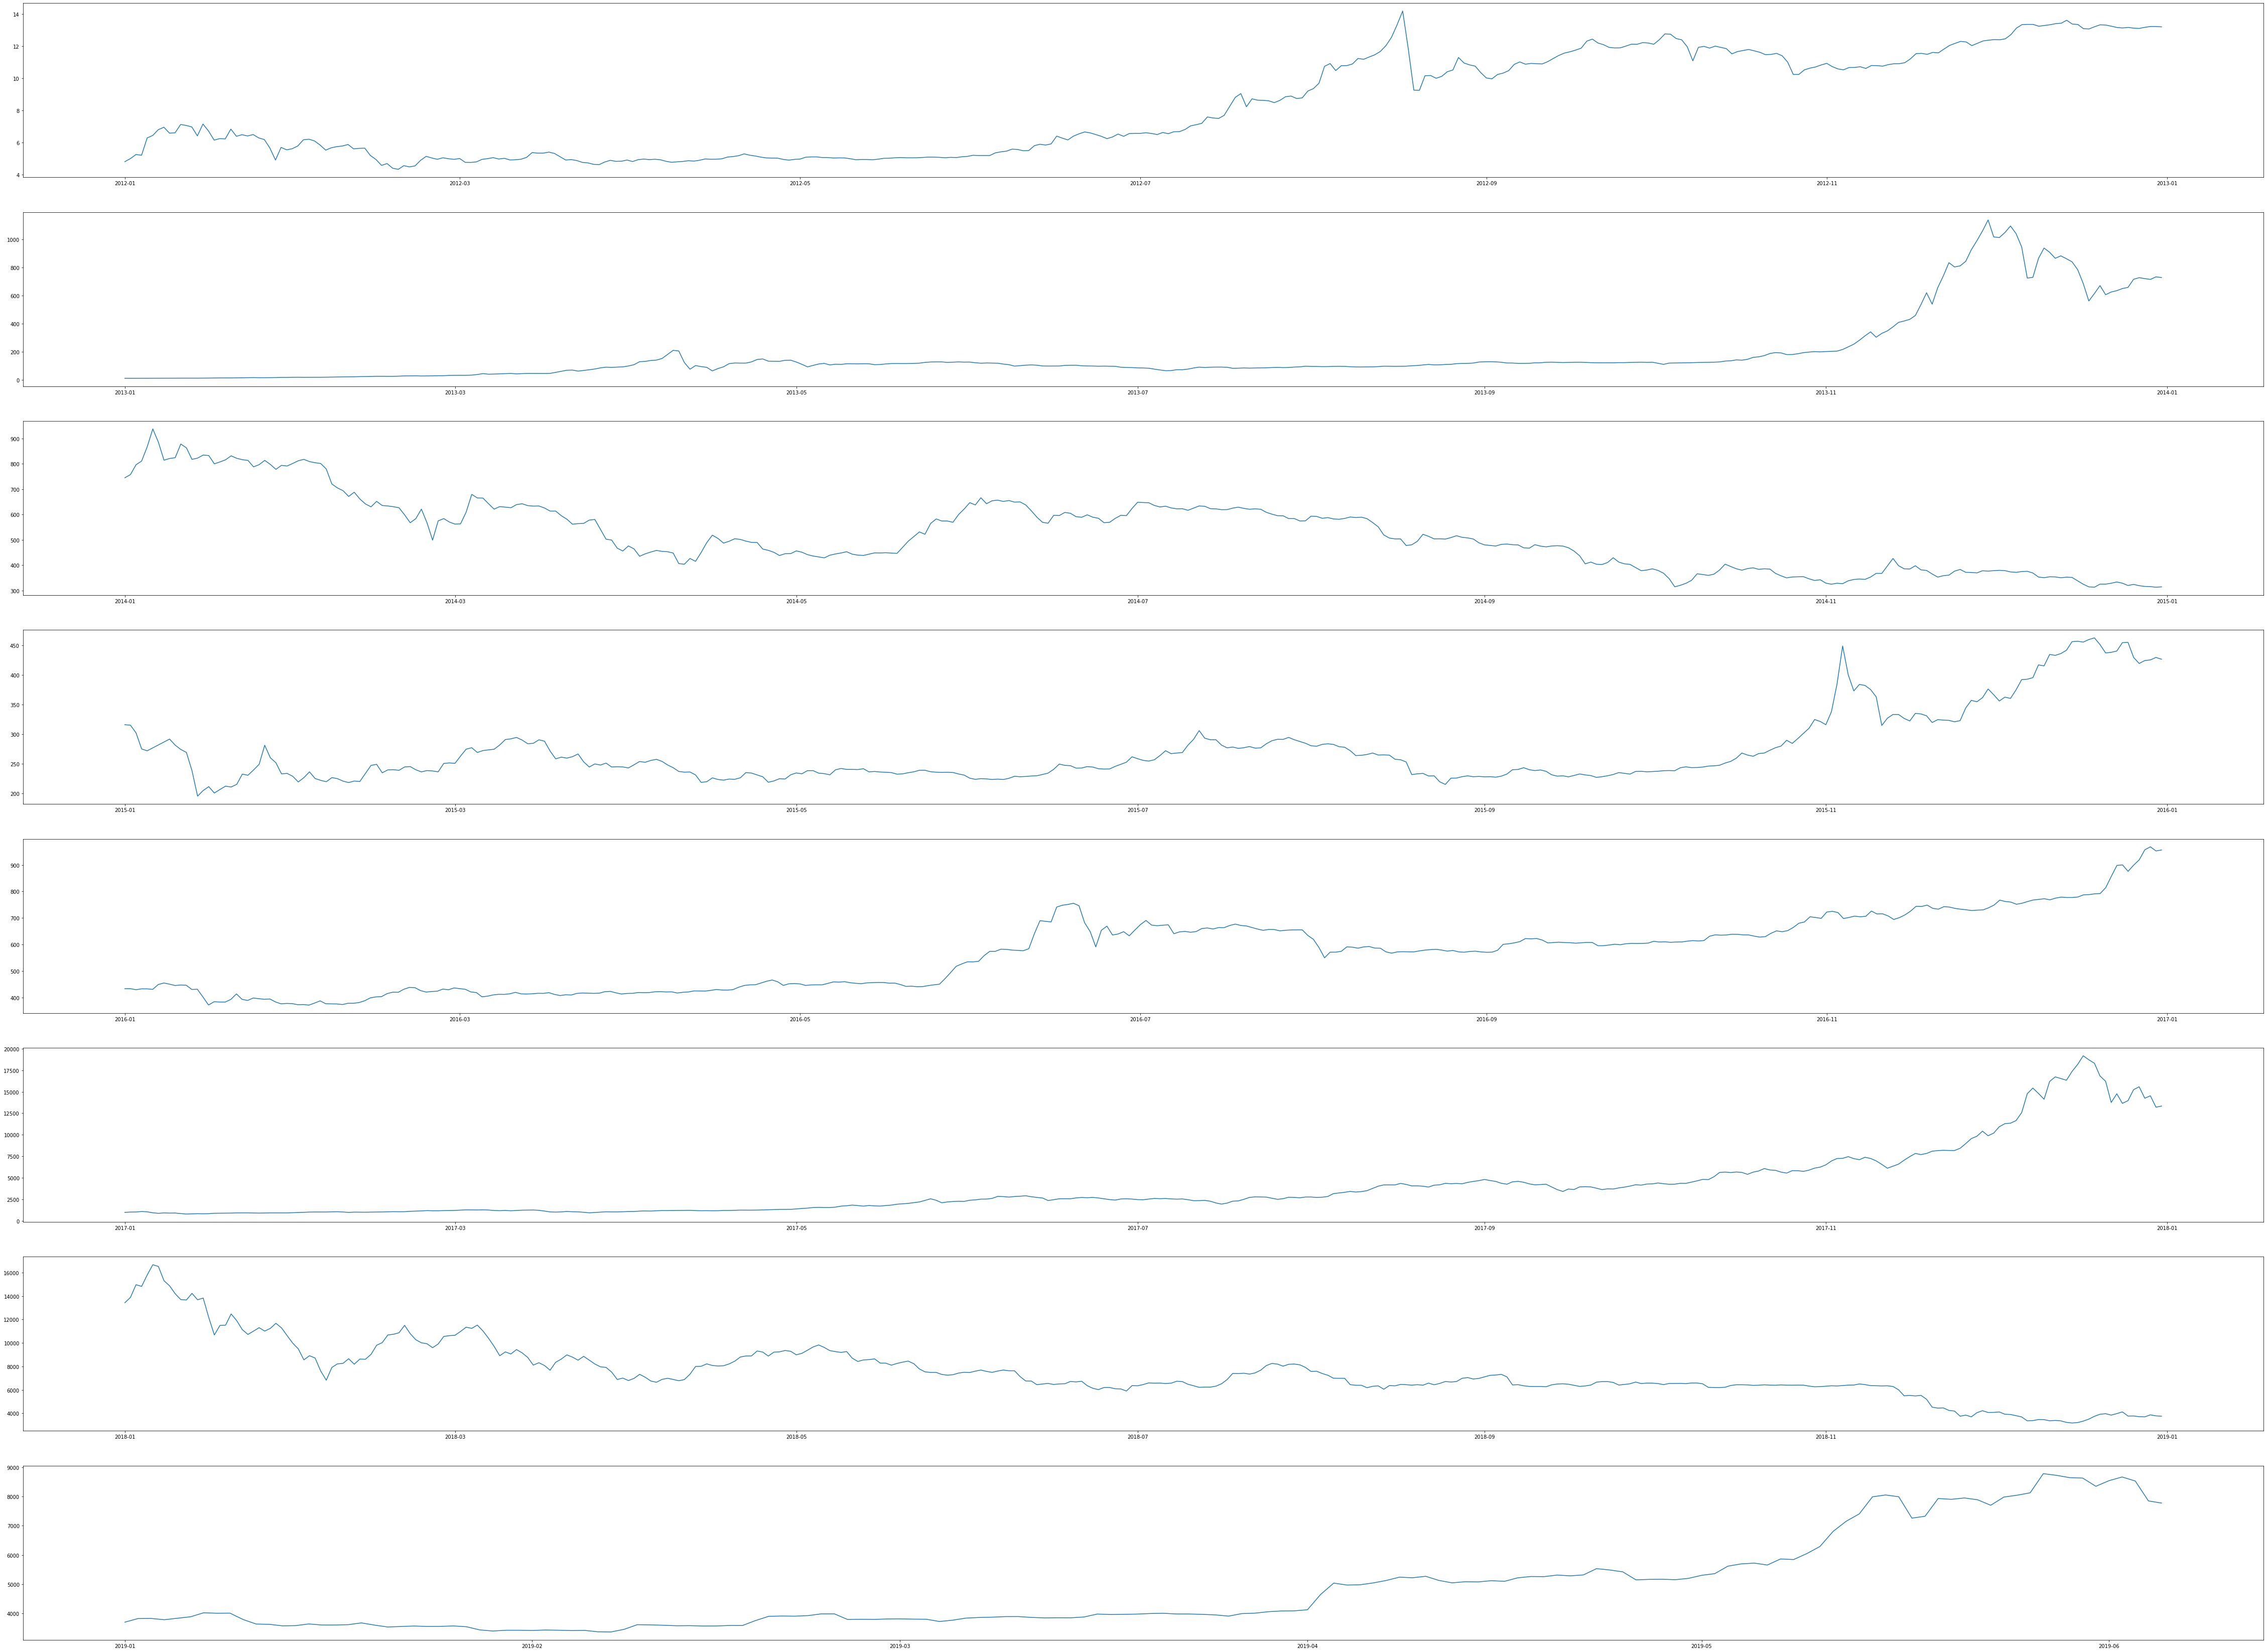

In [16]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(8, figsize=(80, 60))
#y_2012.plot(figsize=(19, 4))
ax1.plot(y_2012)
ax2.plot(y_2013)
ax3.plot(y_2014)
ax4.plot(y_2015)
ax5.plot(y_2016)
ax6.plot(y_2017)
ax7.plot(y_2018)
ax8.plot(y_2019)

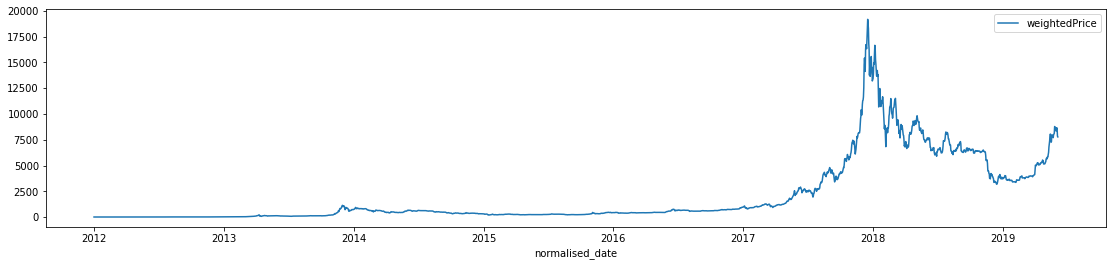

In [17]:
y.plot(figsize=(19, 4))
plt.show()


In [18]:
print(len(y))

2710


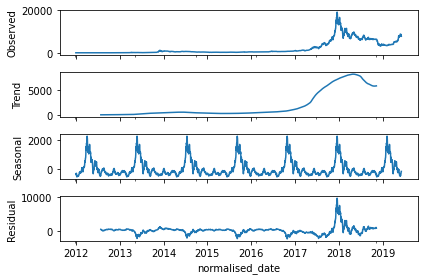

In [24]:
# freq = 416 to represent 1 week as 1 input
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(x=y['weightedPrice'], model='additive', freq=416)
fig = decomposition.plot()
plt.show()

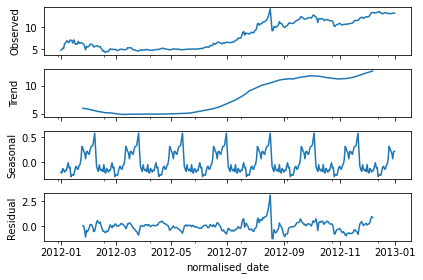

In [25]:
decomposition = seasonal_decompose(x=y_2012, model='additive', freq=48)
fig = decomposition.plot()
plt.show()

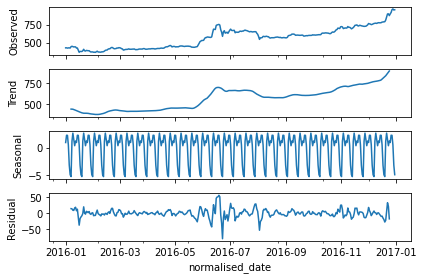

In [ ]:
decomposition = seasonal_decompose(x=y_2016, model='additive', freq=12)
fig = decomposition.plot()
plt.show()

In [26]:
# importing and setting dependencies
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from statsmodels.tsa.statespace.sarimax import SARIMAX

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

In [27]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [28]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:52303.35045311248
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:50270.85242050611
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:43347.40409604621
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:43151.97542732381
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:43359.239838656766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:43326.656254315356
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:43166.45819247828
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:43153.28413727557
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:50306.21469446896
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:45605.20676076604
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:40523.222569131016
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:40355.95082003043
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:40544.29176157709
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:40516.96904650262
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:40384.04371406498
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:40359.533048990445
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:35579.19586079361
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:35435.420315072086
ARIMA

In [30]:
# getting best model parameters based on AIC (lower the better)
# ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:35325.254241830175
# ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:35226.99812943824
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2819      0.021     13.189      0.000       0.240       0.324
ma.L1         -0.0920      0.023     -4.011      0.000      -0.137      -0.047
ma.S.L12      -1.0000      2.005     -0.499      0.618      -4.930       2.930
sigma2      2.879e+04   5.78e+04      0.498      0.618   -8.45e+04    1.42e+05


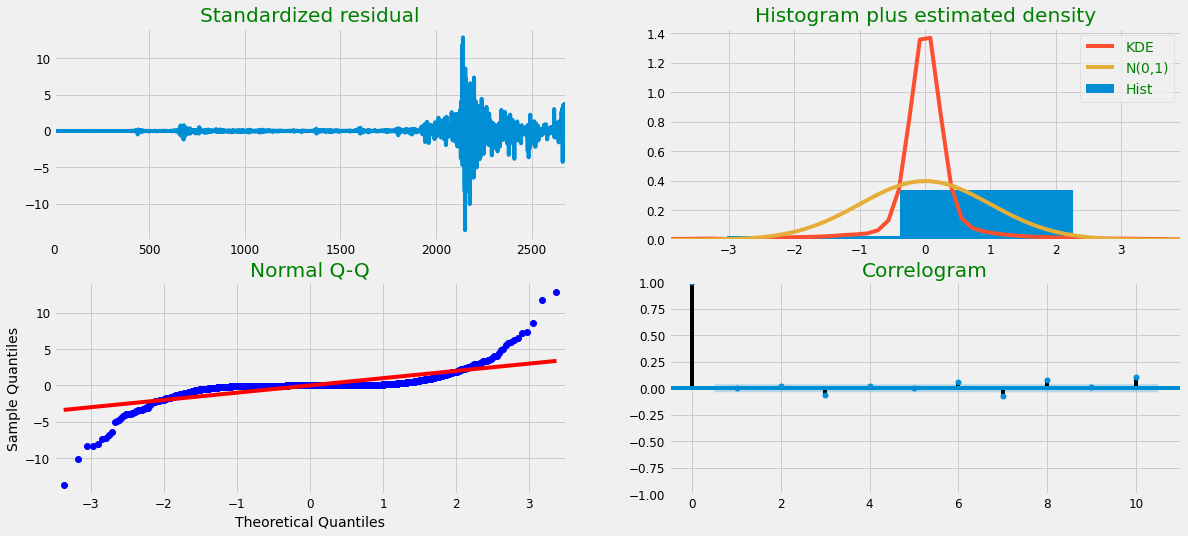

In [31]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [54]:
dt = datetime.date(year=2016,month=6,day=1)
dt64 = np.datetime64(dt)
type(dt64)
y.index.values
y.loc[dt]

weightedPrice    534.133311
Name: 2016-06-01, dtype: float64

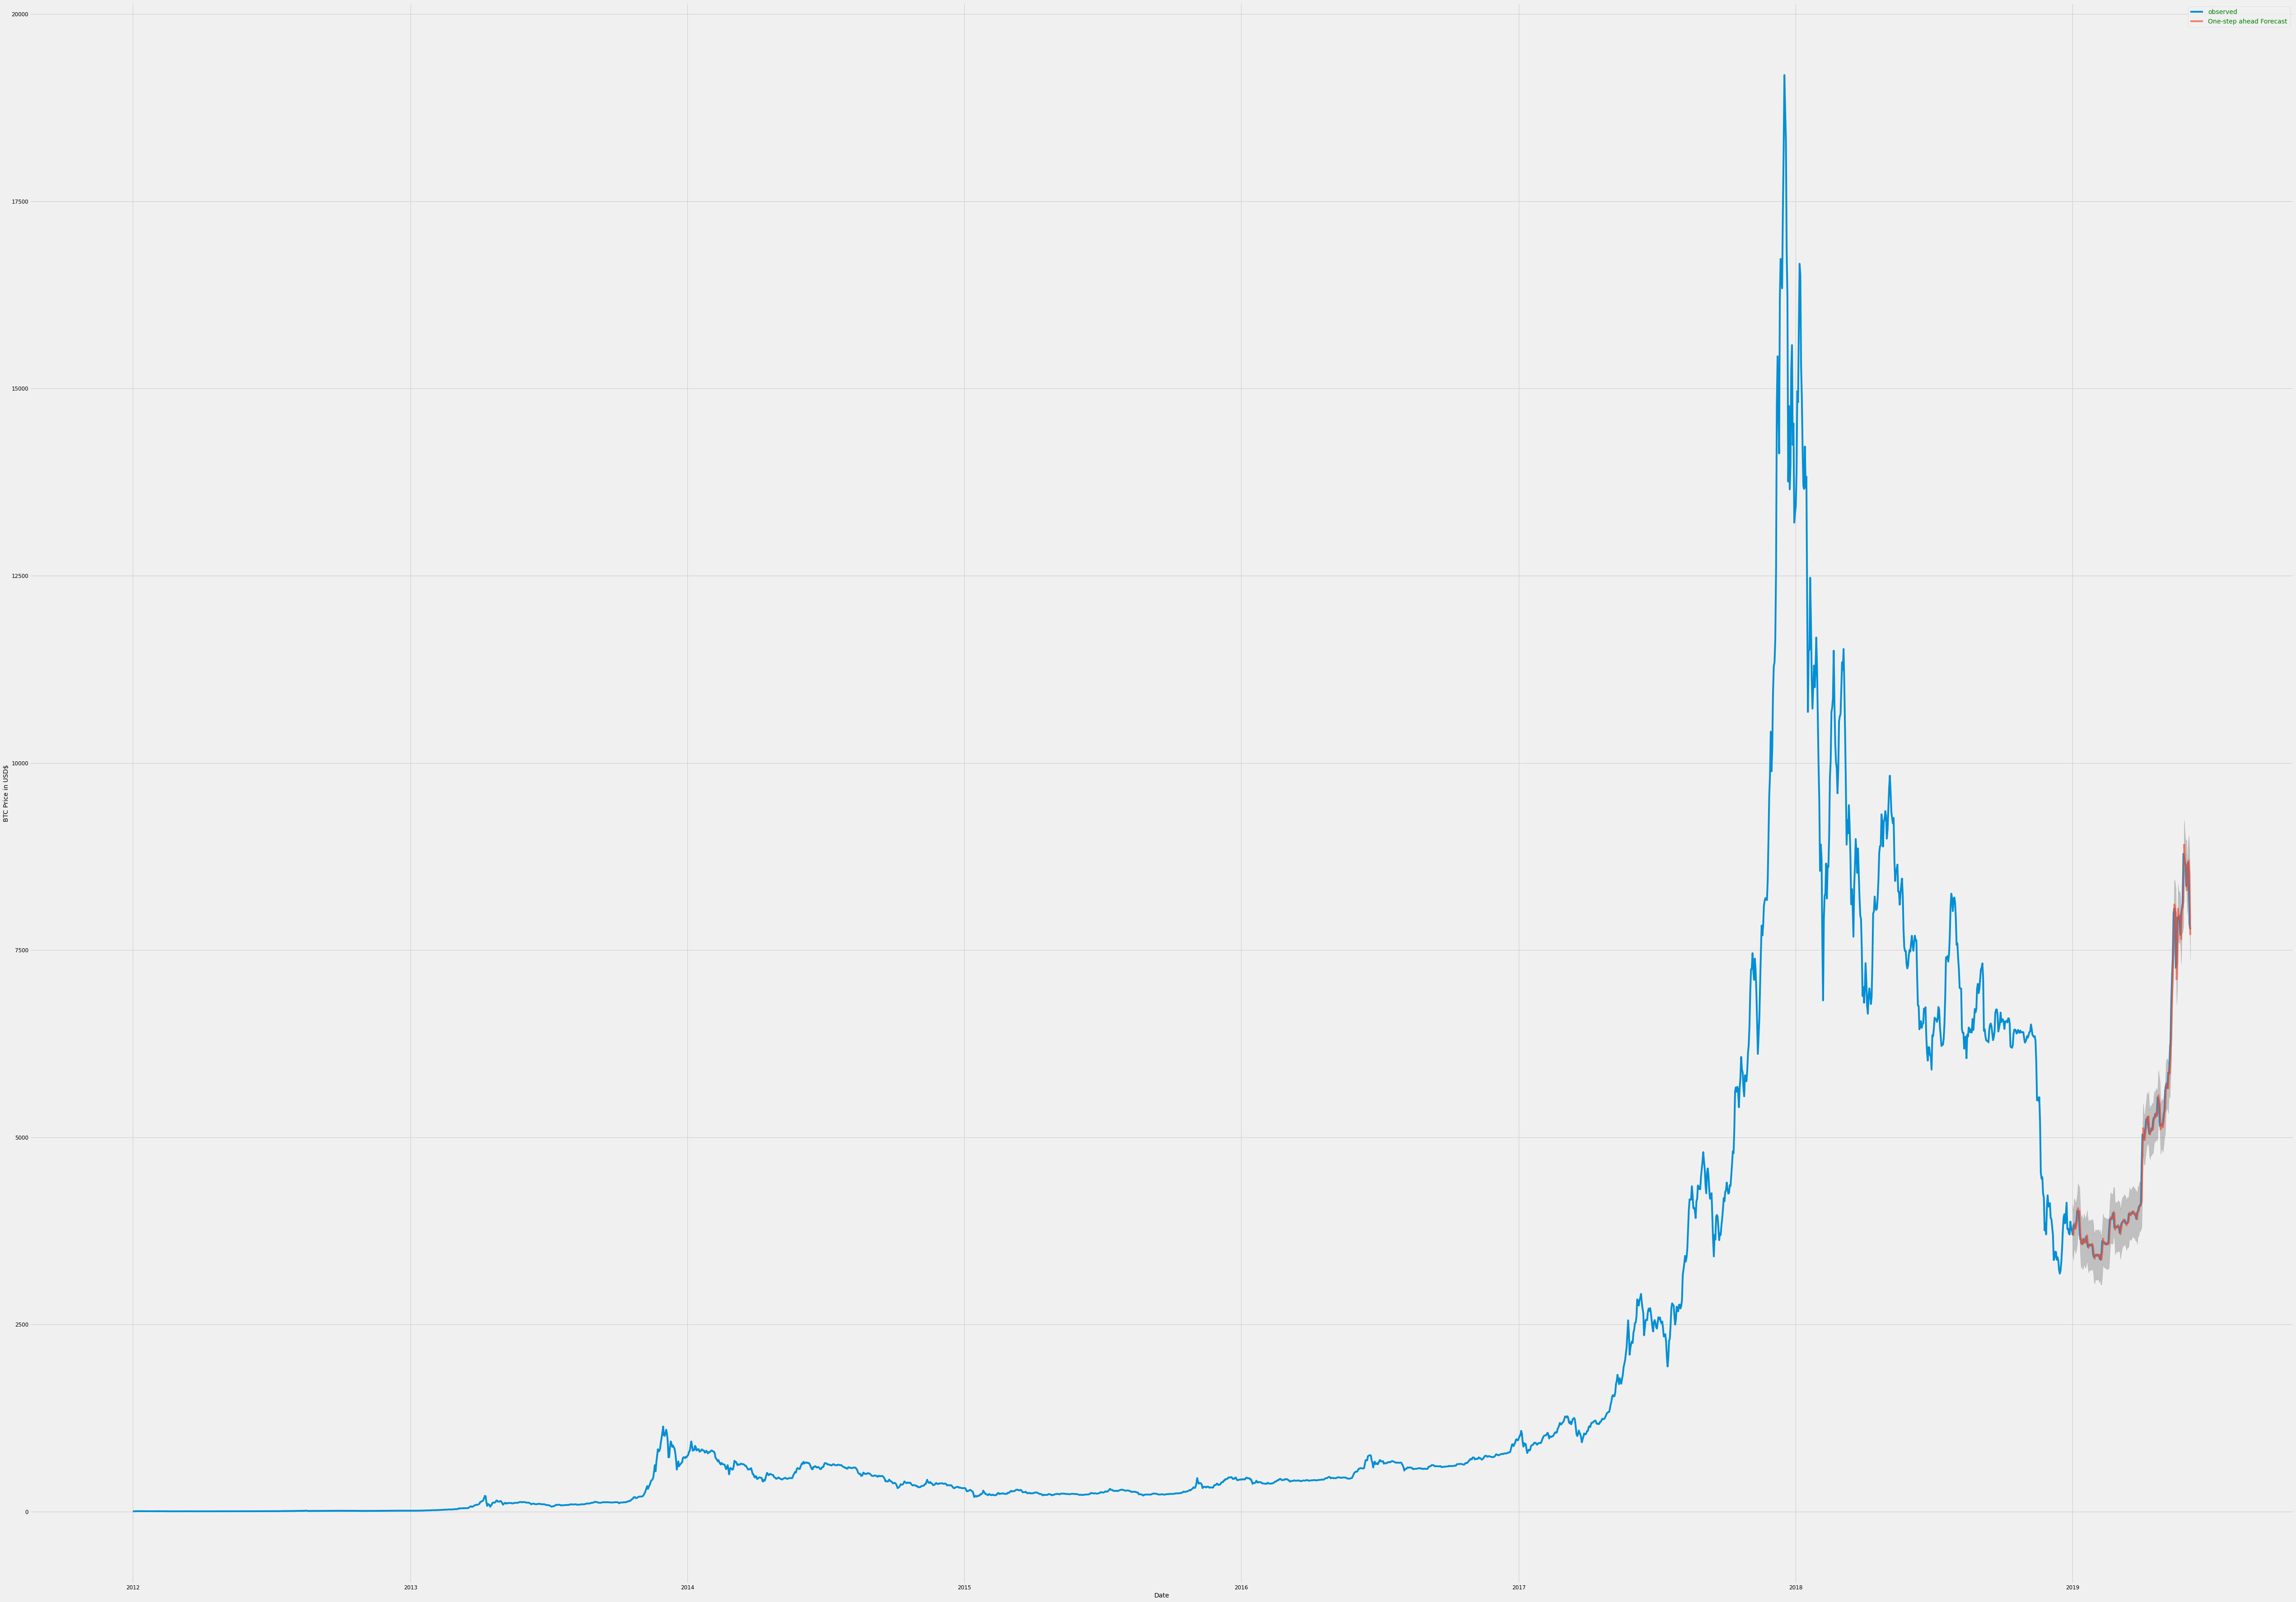

In [57]:
# comparing true values with forecast predictions
# pred = results.get_prediction(start=pd.to_datetime('2016-06-01'), dynamic=False)
# pred = results.get_prediction(start=np.datetime64(datetime.date(year=2016,month=9,day=1)), dynamic=False)
pred = results.get_prediction(start=datetime.date(year=2019,month=1,day=1), dynamic=False)
pred_ci = pred.conf_int()
ax = y['weightedPrice'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(80, 60))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('BTC Price in USD$')
plt.legend()
plt.show()

In [63]:
last_date = y.index[-1]
last_date += datetime.timedelta(days=1)
last_date

datetime.date(2019, 6, 6)

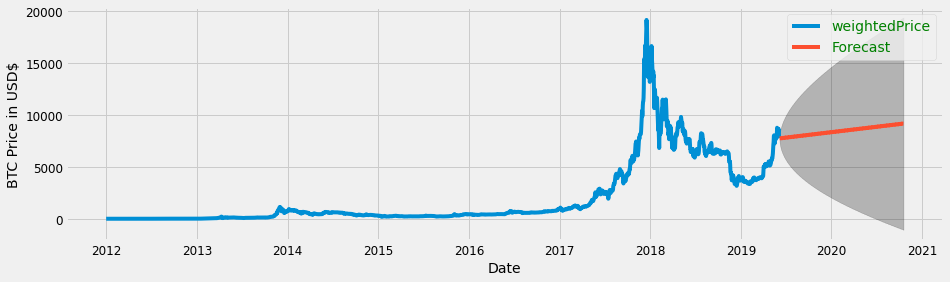

In [83]:
pred_uc = results.get_forecast(steps=500)
pred_ci = pred_uc.conf_int()

pred_uc_df = pd.DataFrame(pred_uc.predicted_mean) 
#pred_ci_df = pd.DataFrame(pred_ci)
pred_indices = []
last_date = y.index[-1]
for i in range(len(pred_ci)):
  last_date += datetime.timedelta(days=1)
  pred_indices.append(last_date)
pred_ci['pred_indices'] = pred_indices
pred_ci = pred_ci.set_index('pred_indices')
  
pred_uc_df['pred_indices'] = pred_indices
pred_uc_df = pred_uc_df.set_index('pred_indices')

ax2 = y.plot(figsize=(14, 4))
pred_uc_df[0].plot(ax=ax2, label='Forecast')
ax2.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax2.set_xlabel('Date')
ax2.set_ylabel('BTC Price in USD$')
plt.legend()
plt.show()


In [79]:
# truth values of dataset
y_forecasted = pred.predicted_mean
y_forecasted.head(12)

normalised_date
2019-01-01    3762.724916
2019-01-02    3693.270229
2019-01-03    3847.712749
2019-01-04    3829.063830
2019-01-05    3776.906048
2019-01-06    3829.549710
2019-01-07    3902.201292
2019-01-08    4053.841364
2019-01-09    4014.243112
2019-01-10    4012.263670
2019-01-11    3763.806048
2019-01-12    3581.641756
dtype: float64

In [80]:
# visualizes upper and lower boundaries 
pred_ci.head(24)

,lower weightedPrice,upper weightedPrice
pred_indices,,
2019-06-06,7432.536014,8099.178650
2019-06-07,7252.000699,8288.187199
2019-06-08,7111.572855,8438.545623
2019-06-09,6987.554153,8557.526807
2019-06-10,6879.438805,8660.879969
2019-06-11,6772.394172,8743.077602
2019-06-12,6692.990573,8836.359897
2019-06-13,6618.314011,8921.480870
2019-06-14,6555.286048,9007.866968


In [81]:
pred_uc_df.columns

Index([0], dtype='object')